# Simulating Diffusion on Surfaces

The simulation scripts described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/tree/master/manual_tutorials/surface_diffusion).

This chapter introduces how to model and simulate surface diffusion systems. In STEPS, surface diffusion means
movement of molecules between triangle elements within a patch and is used to model e.g. mobility of surface receptors
within membranes.

In practice, simulating diffusion in surfaces is analogous to simulating diffusion in volumes as introduced in [Simulating Diffusion in Volumes](diffusion.ipynb),
replacing volume system with surface system and compartment with patch. This section will demonstrate the simple case of free diffusion from
a source on a large circular surface, which is somewhat analogous to free diffusion in a sphere described in [Simulating Diffusion in Volumes](diffusion.ipynb). Therefore the
code in this chapter has obvious similarities to that in [Simulating Diffusion in Volumes](diffusion.ipynb) and we will not dwell on familiar concepts, but will focus on the key differences instead.

After running the spatial stochastic simulation in familiar solver 'Tetexact', we are then introduced to spatial deterministic solver 'TetODE' ([steps.solver.TetODE](API_solver.rst#steps.solver.TetODE)).

## Analytical solution

In the deterministic limit, C, the number of diffusing molecules per unit area, at a distance
r from a point source on an infinite plane surface
at time *t* is (Crank, J. (1975) The Mathematics of Diffusion. Oxford: Clarendon Press):

\begin{equation}
    C(r,t)=\frac{N}{4\pi Dt}\exp\left(\frac{-r^{2}}{4Dt}\right)
\end{equation}


where *N* is the total number of injected molecules and *D* is the diffusion constant (in units $m^{\text{2}}/s$ if length units are metres and time units seconds).


## Modelling solution

### Organisation of code

As for previous models we will create a Python script to run the surface diffusion model. Since we're now familiar with the concept of
building Python scripts to run STEPS models we will no longer use the Python prompt syntax.

First we import STEPS modules and other modules `pylab` and `math`:


In [1]:
import steps.model as smodel
import steps.geom as stetmesh
import steps.utilities.meshio as smeshio
import steps.rng as srng
import steps.solver as solvmod

import pylab
import math

Then we set some constants. This time we will run 100 iterations of the simulation, running each iteration to 21 seconds recording data every 1 second,
each time injecting 1000 molecules which will diffuse by diffusion constant of 0.08 square microns per second:


In [2]:
# Number of iterations; plotting dt; sim endtime:
NITER = 100

# The data collection time increment (s)
DT = 1.0

# The simulation endtime (s)
INT = 21.0

# Number of molecules injected in centre
NINJECT = 1000

# The diffusion constant for our diffusing species (m^2/s)
DCST = 0.08e-12

### Model specification

Now we move on to constructing the biochemical model which, as in [Simulating Diffusion in Volumes](diffusion.ipynb), we will organise into a small function that returns the
important [steps.model.Model](API_model.rst#steps.model.Model) container object. First we'll look at the complete function:


In [3]:
def gen_model():
    mdl = smodel.Model()
    A = smodel.Spec('A', mdl)
    ssys = smodel.Surfsys('ssys', mdl)
    diff_A = smodel.Diff('diffA', ssys, A,  DCST)
    return mdl

Which looks remarkably similar to the model specification function in [Simulating Diffusion in Volumes](diffusion.ipynb), but with one important difference. If we look closely at these lines we see that this time the diffusion rule belongs to a `surface system`. This is the only difference between creating a diffusion rule for a volume (compartment)
or a surface (patch): if the diffusion rule belongs to a volume system (as in [Simulating Diffusion in Volumes](diffusion.ipynb)) the diffusion rule will determine how the specified molecular
species diffuse in any compartments to which that volume system is added, and if the diffusion rule belongs to a surface system ([steps.model.Surfsys](API_model.rst#steps.model.Surfsys) ),
as in this example, it specifies how the species will diffuse in any patch to which that surface system is added.
There is only one [steps.model.Diff](API_model.rst#steps.model.Diff) object that takes care of both eventualities (volume or surface diffusion), adapting behaviour depending on whether
it belongs to a volume system or surface system. Any given species may of course diffuse in both volumes and surfaces (by different diffusion coefficients) and
therefore may appear in both volume and surface diffusion rules in the same model.
Since this is the same [steps.model.Diff](API_model.rst#steps.model.Diff) object as introduced in [Simulating Diffusion in Volumes](diffusion.ipynb#diffusion) its construction is similar and the same general behaviour applies.
To reiterate, the arguments to the constructor are, in order: the usual identifier string,
a reference to the parent surface system, a reference to the molecular species to which this diffusion
rule applies, the diffusion constant (which is an optional parameter to the object constructor) given in s.i. units ($m^{2}/s$). This will become the
value for this diffusion rule wherever it appears in the model. Function [steps.model.Diff.setDcst](API_model.rst#steps.model.Diff.setDcst) is another option for setting the diffusion constant.


### Geometry specification

The next step, as usual, is to create the geometry for the simulation which, as in the previous chapter [Simulating Diffusion in Volumes](diffusion.ipynb), will require a tetrahedral mesh
because this is a diffusion model. This time we will use a flat disk-shaped mesh (of radius 10 microns) and run the diffusion on one of the circular faces.

<img src="images/coin.png" style="width: 6.5in">


Please see previous chapter [Simulating Diffusion in Volumes](diffusion.ipynb) for a more detailed discussion of tetrahedral mesh generation and import. Functions that have already
been described in that chapter will not be described here in detail.

The first step, within a function to group all geometry creation code, is to import the tetrahedral mesh shown in the above figure using
function [steps.utilities.meshio.loadMesh](API_utilities.rst#steps.utilities.meshio.loadMesh), which returns a tuple with a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object as the 0th element.


In [4]:
mesh = smeshio.loadMesh('meshes/coin_10r_1h_13861')[0]

Then we create a compartment (we’ll see why this is necessary soon) comprising all mesh tetrahedrons, which is simply a sequence of indices from 0 up to the total number of tetrahedrons in the mesh:

In [5]:
ntets = mesh.countTets()
comp = stetmesh.TmComp('cyto', mesh, range(ntets))

Next we go on to creating the surface 'patch' object for this mesh-based simulation, a [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) object. This object is comprised of a
collection of triangles, which can be at any
location within the tetrahedral mesh. It's important to realise that triangles appear internally in tetrahedral meshes, not only on the exterior surface, and
internal patches comprising a collection of interior triangles (or even a combination of interior and exterior triangles) are supported in STEPS. This is
essential to allow multiple compartment modelling by one tetrahedral mesh. For example, if a mesh represented a section of a cell separated into cytosol and
intracellular organelle compartments, then the collection of triangles on the exterior surface might represent the cell membrane, with collections of interior
triangles representing organelle membranes. However, in this simple example we wish to create one [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) object consisting of the triangles
that make up one of the circular faces in the mesh (we choose the positive z side of this mesh which is centred on 0,0,0), and therefore consists of part of the
exterior surface. The problem is then to find all exterior surface triangles, then keep only those triangles where all 3 vertices of the triangle have a positive
z value. The functions we need to use are the useful function [steps.geom.Tetmesh.getSurfTris](API_geom.rst#steps.geom.Tetmesh.getSurfTris), which returns all exterior surface triangles on the
mesh, [steps.geom.Tetmesh.getTri](API_geom.rst#steps.geom.Tetmesh.getTri), which returns the indices of the 3 vertices for any triangle, and [steps.geom.Tetmesh.getVertex](API_geom.rst#steps.geom.Tetmesh.getVertex), which
returns the x,y,z coordinates of a vertex in a Python tuple

In [6]:
# Find the indices of the exterior surface triangles
alltris = mesh.getSurfTris()
# Sort patch triangles as those of positive z
patch_tris = []
for t in alltris:
    vert0, vert1, vert2 = mesh.getTri(t)
    if (mesh.getVertex(vert0)[2] > 0.0 \
        and mesh.getVertex(vert1)[2] > 0.0 \
        and mesh.getVertex(vert2)[2] > 0.0):
        patch_tris.append(t)

Now that we have sorted the triangles and have a list ``patch_tris`` containing the collection of circular face triangles we are interested in, we can create the
patch for our spatial simulation: a [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) object. The required arguments to the constructor are, in order: a string identifier, a
reference to the [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) container object, a sequence of the triangles that comprise this patch, and an 'inner' compartment.

In [7]:
patch = stetmesh.TmPatch('patch', mesh, patch_tris, icomp = comp)
patch.addSurfsys('ssys')

The required 'inner' compartment concept requires a little further explanation. In STEPS only tetrahedral meshes are supported (and not, for example, purely
triangular meshes) and therefore all patches are necessarily connected to volumes. However, a patch may be connected to only one compartment, as is the
case here, or two compartments, as would be the case for any internal patches. Following on from convention introduced in well-mixed systems (see [Surface-Volume Reactions (Example: IP3 Model)](ip3.ipynb)),
since distinction is necessary between the two (possible) compartments
connected to a patch they are arbitrarily labelled as 'inner' and 'outer'. If the patch is connected to only one compartment that compartment must
be labelled as the 'inner' compartment to the patch since `icomp` is a required argument to the [steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch) constructor. If the patch is connected to two compartments
one must be labelled the 'inner' compartment (constructor argument `icomp`) and one the 'outer' compartment (constructor argument `ocomp`) and the object construction might look something like

In [8]:
# ER_membrane = stetmesh.TmPatch('ER_membrane', mesh, Er_memb_tris, icomp = endoplasmic_reticulum, ocomp = cytosol)

Returning to our rather more simple model, next we create two empty NumPy arrays for which we will store, for each triangle in the patch, the radial distance to the centre of the patch and the area of the triangle:

In [9]:
# Find out how many triangles are in the patch
patch_tris_n = len(patch_tris)
# Create array to store radial distances
trirads = pylab.zeros(patch_tris_n)
# Create array to store triangle areas
triareas = pylab.zeros(patch_tris_n)

To find the radial distances we need a reference central point. Because the mesh is not perfectly regular the triangle that encompasses coordinates x=0.0, y=0.0 will not
necessarily be centred exactly on x=0.0 y=0.0, so we will instead define the central point as the barycenter of that triangle. To find this triangle we take advantage of
the fact that the triangle is connected to a tetrahedron which is easier to find by coordinates (using function [steps.geom.Tetmesh.findTetByPoint](API_geom.rst#steps.geom.Tetmesh.findTetByPoint)), and then
we need to find the triangle 'neighbours' of that tetrahedron (using function [steps.geom.Tetmesh.getTetTriNeighb](API_geom.rst#steps.geom.Tetmesh.getTetTriNeighb)): the triangle neighbour of the tetrahedron encompassing
coordinate x=0.0, y=0.0, z=0.5 (microns) that also belongs to the patch is the triangle that we want.

In [10]:
# Find the central triangle
# First find the tetrahedron connected to the central triangle
ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.5e-6])
# Find this tetrahedron's neighbours
ctet_trineighbs = mesh.getTetTriNeighb(ctetidx)
# Find which of these (4) neighbours is in the patch
ctri_idx=-1
for t in ctet_trineighbs:
    if t in patch_tris:
        ctri_idx = t

Then we record for each triangle by position in our ``patch_tris`` list, the distance of the barycentre of the triangle to the centre
point (in microns) using function [steps.geom.Tetmesh.getTriBarycenter](API_geom.rst#steps.geom.Tetmesh.getTriBarycenter), and the triangle area (in square microns) using function [steps.geom.Tetmesh.getTriArea](API_geom.rst#steps.geom.Tetmesh.getTriArea).
We will record this information in the arrays `trirads` and `triareas` respectively:

In [11]:
# Now find the distance of the centre of each tri to the central tri
cbaryc = mesh.getTriBarycenter(ctri_idx)
for i in range(patch_tris_n):
    baryc = mesh.getTriBarycenter(patch_tris[i])
    r2 = math.pow((baryc[0]-cbaryc[0]),2) + \
            math.pow((baryc[1]-cbaryc[1]),2) + \
                math.pow((baryc[2]-cbaryc[2]),2)
    r = math.sqrt(r2)
    # Convert to microns
    trirads[i] = r*1.0e6
    triareas[i] = mesh.getTriArea(patch_tris[i])*1.0e12

Finally, we return the important information found within this function.


Our complete geometry function is:

In [12]:
def gen_geom():
    mesh = smeshio.loadMesh('meshes/coin_10r_1h_13861')[0]

    ntets = mesh.countTets()
    comp = stetmesh.TmComp('cyto', mesh, range(ntets))

    alltris = mesh.getSurfTris()
    # Sort patch triangles as those of positive z
    patch_tris = []
    for t in alltris:
        vert0, vert1, vert2 = mesh.getTri(t)
        if (mesh.getVertex(vert0)[2] > 0.0 and mesh.getVertex(vert1)[2] > 0.0 and mesh.getVertex(vert2)[2] > 0.0):
            patch_tris.append(t)

    # Create the patch
    patch = stetmesh.TmPatch('patch', mesh, patch_tris, icomp = comp)
    patch.addSurfsys('ssys')
    patch_tris_n = len(patch_tris)

    trirads = pylab.zeros(patch_tris_n)
    triareas = pylab.zeros(patch_tris_n)

    # Find the central tri
    ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.5e-6])
    ctet_trineighbs = mesh.getTetTriNeighb(ctetidx)
    ctri_idx=-1
    for t in ctet_trineighbs:
        if t in patch_tris:
            ctri_idx = t

    # Now find the distance of the centre of each tri to the central tri
    cbaryc = mesh.getTriBarycenter(ctri_idx)
    for i in range(patch_tris_n):
        baryc = mesh.getTriBarycenter(patch_tris[i])
        r2 = math.pow((baryc[0]-cbaryc[0]),2) + math.pow((baryc[1]-cbaryc[1]),2) + math.pow((baryc[2]-cbaryc[2]),2)
        r = math.sqrt(r2)
        # Convert to microns and square microns
        trirads[i] = r*1.0e6
        triareas[i] = mesh.getTriArea(patch_tris[i])*1e12

    return mesh, patch_tris, patch_tris_n, ctri_idx, trirads, triareas

### Simulation with ``Tetexact``

We're now ready to run the simulation and collect data. First we call the two functions ``gen_model`` and ``gen_geom`` and store references to the important objects
they return, the [steps.model.Model](API_model.rst#steps.model.Model) and [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) container objects, and the patch triangles information (being consistent with their
names in the ``gen_geom`` function to minimise confusion):


In [13]:
model = gen_model()
tmgeom, patch_tris, patch_tris_n, ctri_idx, trirads, triareas = gen_geom()

We then need to create our random number generator object, as usual for stochastic simulations:


In [14]:
rng = srng.create('mt19937', 512)
rng.initialize(234)

And then we can create a `Tetexact` spatial stochastic solver object:


In [15]:
# Create solver object
sim = solvmod.Tetexact(model, tmgeom, rng)

Finally before running a simulation we, similar to previous chapters, create arrays to help run the simulation and to record data:


In [16]:
tpnts = pylab.arange(0.0, INT, DT)
ntpnts = tpnts.shape[0]
# Create the  data structure: iterations x time points x tri samples
res = pylab.zeros((NITER, ntpnts, patch_tris_n))

And we are ready to run the simulation. This will be very similar to the simulation loop in [Simulating Diffusion in Volumes](diffusion.ipynb#diffusion), but instead of injecting and recording molecules from
tetrahedrons, we inject and record from patch triangles with solver methods [steps.solver.Tetexact.setTriCount](API_solver.rst#steps.solver.Tetexact.setTriCount) and [steps.solver.Tetexact.getTriCount](API_solver.rst#steps.solver.Tetexact.getTriCount).
We will inject all molecules in the central triangle (to approximate a point source) and record molecules from each triangle in the patch. We'll use the `triareas` data
to record, in the `res` results array, molecule number per square micron. The complete simulation loop is:


In [17]:
from __future__ import print_function # for backward compatibility with Py2


# Run NITER number of iterations:
for j in range(NITER):
    if not j%10: print("Running iteration ", j)
    sim.reset()
    sim.setTriCount(ctri_idx, 'A', NINJECT)
    for i in range(ntpnts):
        sim.run(tpnts[i])
        for k in range(patch_tris_n):
            res[j, i, k] = sim.getTriCount(patch_tris[k], 'A')/triareas[k]

Running iteration  0
Running iteration  10
Running iteration  20
Running iteration  30
Running iteration  40
Running iteration  50
Running iteration  60
Running iteration  70
Running iteration  80
Running iteration  90


To look at the mean molecule density over all iterations for ease of comparison to the analytical solution we use the ``numpy.mean`` function as in
previous chapters:


In [18]:
res_mean = pylab.mean(res, axis = 0)

### Plotting simulation output

As we are quite familiar with plotting STEPS output now we won't dwell on the details. As in [Simulating Diffusion in Volumes](diffusion.ipynb) we wish to also plot the analytical solution alongside our
STEPS output for comparison, where the solution is of a similar form to that for unbounded volume diffusion. We create two functions
to take care of all our plotting needs. The first function plots the results:


In [19]:
def plotres(res_mean, tidx):
    if (tidx >= INT/DT):
        print("Time index is out of range.")
        return
    pylab.scatter(trirads, res_mean[tidx], s=10)
    pylab.xlabel('Radial distance ($\mu$m)')
    pylab.ylabel('Concentration (/$\mu$m$^2$)')
    t = tpnts[tidx]
    pylab.title('Unbounded surface diffusion. Time: ' + str(t) + 's')
    plotanlyt(t)
    pylab.xlim(0,10)
    pylab.ylim(0)
    pylab.show()

And the second function (which is called within the `plotres` function) plots the analytical solution, this time as number of molecules per square micron:


In [20]:
def plotanlyt(t):
    segs = 100
    anlytconc = pylab.zeros((segs))
    radialds = pylab.zeros((segs))
    maxrad = 0.0
    for i in trirads:
            if (i > maxrad): maxrad = i
    maxrad *= 1e-6
    intervals = maxrad/segs
    rad = 0.0
    for i in range((segs)):
            anlytconc[i]=(NINJECT/(4*math.pi*DCST*t))* \
        (math.exp((-1.0*(rad*rad))/(4*DCST*t)))*1e-12
            radialds[i] = rad*1e6
            rad += intervals
    pylab.plot(radialds, anlytconc, color = 'red')

And that is everything that we need to run our surface diffusion simulation, plot the results and compare to the analytical solution. After running the simulation simply
by importing this module, we can then plot data at any of the "time points" with a function call such as:


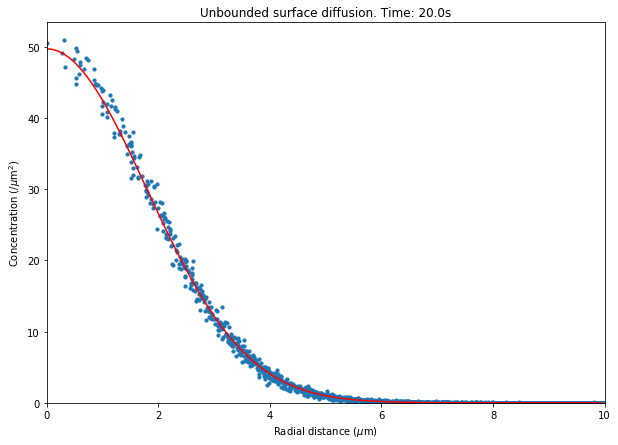

In [21]:
pylab.figure(figsize=(10,7))
plotres(res_mean, 20)

Here we plotted the mean surface density of diffusing species `A` in individualtriangles in STEPS (black dots) is plotted with the analytical solution from the above equation (red).There is a small discrepancy near the centre of the surface due to the injection of molecules into a finite area inSTEPS whereas a point source is assumed for the analytical solution. STEPS output shows some noise due to the effects of stochastic surface diffusion.

### Simulation with ``TetODE``

Another option for spatial simulation is to use the deterministic solver 'TetODE' ([steps.solver.TetODE](API_solver.rst#steps.solver.TetODE)). TetODE shares many similarities with Tetexact
in terms of model and geometry construction operating on the same tetrahedral meshes, but solutions are deterministic. TetODE uses
CVODE (http://computation.llnl.gov/casc/sundials/description/description.html) for solutions. Although solutions are therefore
very different between solver Tetexact and TetODE, in terms of simulation construction there are only a few implementation differences.
Therefore, we can use almost the exact same code as already introduced to run the deterministic unbounded
surface diffusion model, with a few changes highlighted below.


Firstly, since TetODE solutions are deterministic, we do not need to run more than one iteration so we set


In [22]:
NITER = 1 

Nothing needs to change for the model and geometry descriptions, and we can go on to creating the [steps.solver.TetODE](API_solver.rst#steps.solver.TetODE) solver
object. As a deterministic solver, TetODE does not require a random number generator so that does not need to be created and can be omitted
from the object construction step.


Finally, the `reset` solver function is not available for TetODE (in part because only one simulation iteration need be run per model), so we remove the call to `sim.reset()`.

from our simulation loop. Theses changes are all we minimally need to do to switch this simulation to deterministic mode using solver TetODE. However,
there are two important additions to this solver, the functions [steps.solver.TetODE.setTolerances](API_solver.rst#steps.solver.TetODE.setTolerances) and [steps.solver.TetODE.setMaxNumSteps](API_solver.rst#steps.solver.TetODE.setMaxNumSteps).
To understand what these functions do requires a little background of how CVODE works. Although there will only be a brief explanation here, thorough descriptions
are available in CVODE documentation (http://computation.llnl.gov/casc/sundials/documentation/cv_guide.pdf).

Solving STEPS models in CVODE
requires supplying information of all the variables in a STEPS simulation at any time as a state vector to the CVODE solver. The variables in STEPS
are the molecular species, which have unique populations in individual mesh elements (tetrahedrons and triangles) meaning that
the state vector can be rather large (number_volume_specs*number_tetrahedrons + number_surface_specs*number_triangles). STEPS
must also supply a function that describes the rate of change of each of these variables with time depending on other variables in the system. CVODE then finds
approximate solutions (here STEPS choses the recommended Adams-Moulton formulas with functional iteration) when the system
advances in time.

To do this it takes a number of 'steps', each time estimating the local error and comparing to tolerance conditions: if the
test fails, step size is reduced, and this is repeated until tolerance conditions are met. This means that there is a tradeoff between accuracy
and simulation speed- with a high tolerance, steps sizes will be large and few steps will have to be taken to advance the simulation some amount of time
though accuracy will be low, with low tolerance, steps sizes will be small so a large number of steps will be taken to advance the simulation although
accuracy will be high. Therefore, the tolerance is an important consideration both for accuracy and efficiency.

STEPS users can control the
tolerances with function  [steps.solver.TetODE.setTolerances](API_solver.rst#steps.solver.TetODE.setTolerances). Two different types of tolerance are specified: relative tolerance and absolute
tolerance, and in STEPS both are scalars. Relative tolerance controls relative errors so that e.g. $10^{-3}$  means that errors are controlled to
0.1% (and it is not recommended to go any higher than that). Absolute tolerances can be useful when any components of the vector approach very small numbers
when relative error control becomes meaningless. The absolute values in the internal state vectors within TetODE are the (fractional) number
of molecules per tetrahedron or triangle, so if a user specifies an absolute tolerance of $10^{-3}$  it means that populations
within tetrahedrons and triangles will be accurate to within 1/1000th of a molecule! In TetODE only one value each for absolute tolerance and relative
tolerance can be specified, and will be applied to all species in all locations in the system. The default value for both absolute tolerance and relative
tolerance is $10^{-3}$ .

We set tolerances with a call to function [steps.solver.TetODE.setTolerances](API_solver.rst#steps.solver.TetODE.setTolerances): the first function argument is
absolute tolerance, the second is relative tolerance. In this example we set an absolute tolerance of  $10^{-3}$  and relative tolerance of $10^{-4}$  with `sim.setTolerances(1e-3, 1e-4)`.

Closely related to this is the function [steps.solver.TetODE.setMaxNumSteps](API_solver.rst#steps.solver.TetODE.setMaxNumSteps), which is a kind of safety device to stop the simulation if advancement is
unacceptably slow. If tolerances are too low, or simulation time step too large, then a large number of steps in CVODE may be taken
before it reaches the requested output time. For example, if we are at time 0 seconds and we ask CVODE to advance the simulation 1 second with function call  `sim.run(1)`.

and CVODE finds acceptable accuracy with a step of approximately 10ms, then roughly 100 steps will be taken until it reaches 1 second, which is generally OK. If,
however, tolerances have been set too low and acceptable accuracy comes at a step of 1µs in CVODE, then a million steps would have to be taken to get to
1 second, and here we probably wouldn't want to go ahead with that situation, adjusting tolerances to give a larger CVODE step instead. And so we use function
[steps.solver.TetODE.setMaxNumSteps](API_solver.rst#steps.solver.TetODE.setMaxNumSteps) to tell CVODE what is the maximum number of steps we will accept each time it tries to advance the simulation,
exiting if it ever reaches the upper limit. The default value is rather large at 10000. We can set a lower limit for this simulation, e.g. 50, with `sim.setMaxNumSteps(50)`.


If we tried to set a maximum number of steps to 10 instead, with these tolerance levels this simulation would fail indicating that somewhere
between 10 and 100 steps are taken each time CVODE advances this simulation (i.e. each time a call is made to [steps.solver.TetODE.run](API_solver.rst#steps.solver.TetODE.run)).


We can now run the simulation and plot the results.

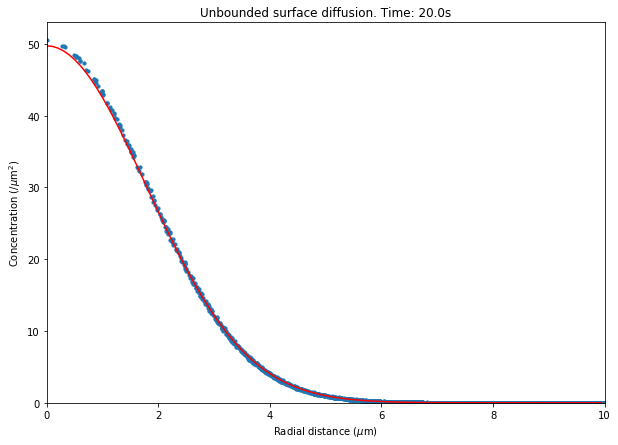

In [23]:
# Create solver object
sim = solvmod.TetODE(model, tmgeom)
sim.setTolerances(1e-3, 1e-4)
sim.setMaxNumSteps(50)

tpnts = pylab.arange(0.0, INT, DT)
ntpnts = tpnts.shape[0]

# Create the  data structure: iterations x time points x tri samples
res = pylab.zeros((NITER, ntpnts, patch_tris_n))

# Run NITER number of iterations:
for j in range(NITER):
    sim.setTriCount(ctri_idx, 'A', NINJECT)
    for i in range(ntpnts):
        sim.run(tpnts[i])
        for k in range(patch_tris_n):
            res[j, i, k] = sim.getTriCount(patch_tris[k], 'A')/ \
                            triareas[k]

res_mean = pylab.mean(res, axis = 0)

pylab.figure(figsize=(10,7))
plotres(res_mean, 20)